%pip install datasets
%pip install transformers
%pip install sentencepiece
%pip install diffusers --upgrade
%pip install invisible_watermark accelerate safetensors
%pip install accelerate
%pip install evaluate

# Image Classification Model
In this notebook we implement the model which will be used to provide a classification for the art pieces that we provide. The model implemented is a visual Transformer, which takes the label of the image and the image itself and provides one of the chosen classifications.
 

In [22]:
import pandas as pd
import torch
import torchvision
import numpy as np
from PIL import Image, ImageFile
Image.LOAD_TRUNCATED_IMAGES = True
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
data = pd.read_csv('../described_dataset_label.csv',sep='\t',encoding='latin-1')
data = data[:10000]
data = data.rename(columns={'FILE':'image','AUTHOR':'author', 'TITLE': 'title', 'TECHNIQUE':'style'})
data = data[['image','author','style','title']]
data['image'] = [f'.{x}' for x in data['image']]
print(f'columns:{[x for x in data.columns]}')

columns:['image', 'author', 'style', 'title']


### Label Tokenization
To facilitate feeding labels into the model, we tokenize them by pairing each unique label with a corresponding index. For instance:
- **Label**: "Leonardo DaVinci" -> **ID**: 3



In [24]:
labels_auth = data['author'].unique()
label2id_auth, id2label_auth = dict(), dict()
for i, label in enumerate(labels_auth):
    label2id_auth[label]=i
    id2label_auth[i]=label

In [25]:
labels_sty = data['style'].unique()
label2id_sty, id2label_sty = dict(), dict()
for i, label in enumerate(labels_sty):
    label2id_sty[label]=i
    id2label_sty[i]=label

In [26]:
labels_title = data['style'].unique()
label2id_title, id2label_title = dict(), dict()
for i, label in enumerate(labels_title):
    label2id_title[label]=i
    id2label_title[i]=label

In [27]:
data['author'] = data['author'].map(label2id_auth)
data['style'] = data['style'].map(label2id_sty)
data['title'] = data['title'].map(label2id_title)
data.columns

Index(['image', 'author', 'style', 'title'], dtype='object')

### Image Processing
Achieving optimal results from our model necessitates preprocessing the images. Key steps in this process include:

#### Standardization
To enable image normalization, we compute both the **mean** and the **standard deviation** of the images. Since image sizes can vary, we first standardize them by resizing all images to a uniform size of 256x256 pixels.

#### Mean and Standard Deviation Calculation
We calculate the mean and standard deviation of the images to aid in normalization. This statistical information is crucial for ensuring consistent and effective preprocessing across the dataset.

#### Transformation Pipeline
The actual image processing is orchestrated using the `Compose` function from the `transforms` library. This function allows us to construct a pipeline of operations to be applied to each image systematically. By automating this process across the entire dataset, we ensure consistency and efficiency in image preprocessing.

### Transformation Details
We define separate transformation pipelines for both training and testing datasets, encompassing operations such as resizing, center cropping, converting to tensors, and normalization. Additionally, for the training dataset, we incorporate data augmentation techniques such as random rotation and horizontal flipping to enhance the model's robustness and generalization ability.


In [28]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

img_tr = [transform(Image.open(img)) for img in tqdm(data['image'])]

mean,std = img_tr[0].mean(),img_tr[0].std()

  0%|          | 30/10000 [00:00<01:43, 96.43it/s]

In [ ]:
mean,std = img_tr[0].mean([1,2]),img_tr[0].std([1,2])
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([0.4685, 0.3801, 0.3472])
Std of the image: tensor([0.2129, 0.1872, 0.1589])


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    ])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    ])

class ArtDataset(torch.utils.data.Dataset):

    def __init__(self,images,labels,transform=None,):
        self.data = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_pil = Image.open(self.data[index])
        img_pil = img_pil.convert('RGB')
        if self.transform is not None:
            img_pil = self.transform(img_pil)
        label = torch.tensor(self.labels[index])
        return(img_pil,label)

## Author Train and Eval data

In [ ]:
# Split train into train and val for the author lable
X_train_auth, X_val_auth, y_train_auth, y_val_auth = train_test_split(data['image'],data['author'], test_size=0.2, random_state=42)
train_dataset_auth = ArtDataset(X_train_auth.values,y_train_auth.values,transform=train_transform)
val_dataset_auth = ArtDataset(X_val_auth.values,y_val_auth.values,transform=test_transform)

## Style Train and Eval data

In [ ]:
# Split train into train and val for the author lable
X_train_style, X_val_style, y_train_style, y_val_style = train_test_split(data['image'],data['style'], test_size=0.2, random_state=42)
train_dataset_style = ArtDataset(X_train_style.values,y_train_style.values,transform=train_transform)
val_dataset_style = ArtDataset(X_val_style.values,y_val_style.values,transform=test_transform)

## Title Train and Eval data

In [ ]:
# Split train into train and val for the author lable
X_train_title, X_val_title, y_train_title, y_val_title = train_test_split(data['image'],data['title'], test_size=0.2, random_state=42)
train_dataset_title = ArtDataset(X_train_title.values,y_train_title.values,transform=train_transform)
val_dataset_title = ArtDataset(X_val_title.values,y_val_title.values,transform=test_transform)

## Create Dataloader

In [ ]:
batch_size = 32
trainloader_auth = DataLoader(train_dataset_auth, batch_size=batch_size, shuffle=True)
testloader_auth = DataLoader(val_dataset_auth, batch_size=batch_size, shuffle=False)
trainloader_style = DataLoader(train_dataset_style, batch_size=batch_size, shuffle=True)
testloader_style = DataLoader(val_dataset_style, batch_size=batch_size, shuffle=False)
trainloader_title = DataLoader(train_dataset_title, batch_size=batch_size, shuffle=True)
testloader_title = DataLoader(val_dataset_title, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


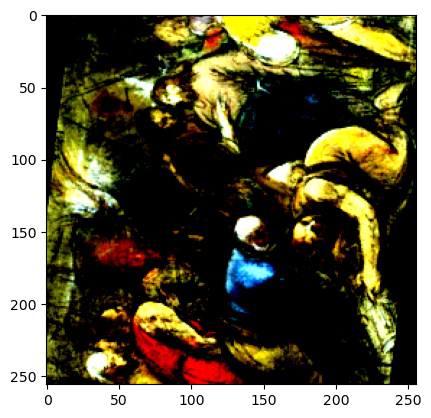

Author: 244


In [ ]:
features, labels = next(iter(trainloader_auth))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")
img = features[0].squeeze()
label = labels[0]
plt.imshow(img.permute(*torch.arange(img.ndim - 1, -1, -1)))
plt.show()
print(f"Author: {label}")

## The Model

Regarding the model, we decided to go with a Convolutional Neural Network (CNN) augmented with visual attention mechanisms.

### AttentionBlock

To enhance the model's ability to focus on relevant regions within the input images, we designed and implemented the AttentionBlock. This component enables the network to dynamically adjust the importance of local features based on their relevance to the task at hand. By incorporating attention mechanisms, we aimed to improve the model's discriminative power and performance, particularly in scenarios where selective feature attention is beneficial.


In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv2d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.W_g = nn.Conv2d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.phi = nn.Conv2d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)
    def forward(self, l, g):
        N, C, W, H = l.size()
        l_ = self.W_l(l)
        g_ = self.W_g(g)
        if self.up_factor > 1:
            g_ = F.interpolate(g_, scale_factor=self.up_factor, mode='bilinear', align_corners=False)
        c = self.phi(F.relu(l_ + g_)) # batch_sizex1xWxH
        
        # compute attn map
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)
        # re-weight the local feature
        f = torch.mul(a.expand_as(l), l) # batch_sizexCxWxH
        if self.normalize_attn:
            output = f.view(N,C,-1).sum(dim=2) # weighted sum
        else:
            output = F.adaptive_avg_pool2d(f, (1,1)).view(N,C) # global average pooling
        return a, output

### Transfer Learning with VGG16

Initially, we attempted to implement the VGG network architecture from scratch. However, due to the computational complexity and time constraints associated with training such a deep network, we opted for transfer learning. Specifically, we leveraged the pre-trained VGG16 model as our base network.

By utilizing transfer learning, we could benefit from the features learned by VGG16 on a large dataset (e.g., ImageNet) and focus our efforts on fine-tuning the model for our specific task. This approach significantly reduced the training time and computational resources required while still enabling us to achieve satisfactory performance.


In [ ]:
# #VGG
# class VGG(nn.Module):
#     def __init__(self, num_classes):
#         super(VGG,self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#         )
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2)
#         )
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#         )
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2)
#         )
#         self.layer5 = nn.Sequential(
#             nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#         )
#         self.layer6 = nn.Sequential(
#             nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#         )
#         self.layer7 = nn.Sequential(
#             nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2)
#         )
#         self.layer8 = nn.Sequential(
#             nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#         )
#         self.layer9 = nn.Sequential(
#             nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#         )
#         self.layer10 = nn.Sequential(
#             nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2)
#         )
#         self.layer11 = nn.Sequential(
#             nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#         )
#         self.layer12 = nn.Sequential(
#             nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#         )
#         self.layer13 = nn.Sequential(
#             nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2)
#         )
#         # self.fc = nn.Sequential(
#         #     nn.Dropout(0.5),
#         #     nn.Linear(7*7*512,4096),
#         #     nn.ReLU(),
#         # )
#         # self.fc1 = nn.Sequential(
#         #     nn.Dropout(0.5),
#         #     nn.Linear(4,4096),
#         #     nn.ReLU(),
#         # )
#         # self.fc2 = nn.Sequential(
#         #     nn.Linear (4096, num_classes))
        
#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = self.layer5(x)
#         x = self.layer6(x)
#         l = self.layer7(x)
#         x = self.layer8(l)
#         x = self.layer9(x)
#         x = self.layer10(x)
#         x = self.layer11(x)
#         x = self.layer12(x)
#         g = self.layer13(x)
#         x = x.reshape(x.size(0),-1)
#         # x = self.fc(x)
#         # x = self.fc1(x)
#         # x = self.fc2(x)
#         return x

### Construction of Our Model

Building upon the VGG16 base, we constructed our network by adding additional layers and incorporating attention mechanisms. This allowed us to tailor the model to our particular classification task while capitalizing on the robust feature extraction capabilities of VGG16.


### Benefits of Transfer Learning and Attention Mechanisms

Utilizing transfer learning with VGG16 and integrating attention mechanisms provided several advantages:
- **Time Efficiency:** Transfer learning expedited the model development process by leveraging pre-trained weights, reducing the need for extensive training on our dataset.
- **Performance Enhancement:** Attention mechanisms allowed the model to focus on salient features, potentially improving classification accuracy and robustness.
- **Resource Conservation:** By reusing pre-trained weights and incorporating attention mechanisms, we optimized resource utilization, making the model more practical for deployment in resource-constrained environments.


In [ ]:
class ArtCNN(nn.Module):
    def __init__(self, num_classes, normalize_attn=False, dropout=None):
        super(ArtCNN, self).__init__()
        net = torchvision.models.vgg16_bn(weights=torchvision.models.VGG16_BN_Weights.DEFAULT)
        self.conv_block1 = nn.Sequential(*list(net.features.children())[0:6])
        self.conv_block2 = nn.Sequential(*list(net.features.children())[7:13])
        self.conv_block3 = nn.Sequential(*list(net.features.children())[14:23])
        self.conv_block4 = nn.Sequential(*list(net.features.children())[24:33])
        self.conv_block5 = nn.Sequential(*list(net.features.children())[34:43])
        self.pool = nn.AdaptiveAvgPool2d(7)
        self.dpt = None
        if dropout is not None:
            self.dpt = nn.Dropout(dropout)
        self.cls = nn.Linear(in_features=25856, out_features=num_classes, bias=True)
        
       # initialize the attention blocks defined above
        self.attn1 = AttentionBlock(256, 512, 256, 4, normalize_attn=normalize_attn)
        self.attn2 = AttentionBlock(512, 512, 256, 2, normalize_attn=normalize_attn)
        
       
        self.reset_parameters(self.cls)
        self.reset_parameters(self.attn1)
        self.reset_parameters(self.attn2)
    def reset_parameters(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0., 0.01)
                nn.init.constant_(m.bias, 0.)
    def forward(self, x):
        block1 = self.conv_block1(x)       # /1
        pool1 = F.max_pool2d(block1, 2, 2) # /2
        block2 = self.conv_block2(pool1)   # /2
        pool2 = F.max_pool2d(block2, 2, 2) # /4
        block3 = self.conv_block3(pool2)   # /4
        pool3 = F.max_pool2d(block3, 2, 2) # /8
        block4 = self.conv_block4(pool3)   # /8
        pool4 = F.max_pool2d(block4, 2, 2) # /16
        block5 = self.conv_block5(pool4)   # /16
        pool5 = F.max_pool2d(block5, 2, 2) # /32
        N, __, __, __ = pool5.size()

        g = self.pool(pool5).view(N,-1)
        a1, g1 = self.attn1(pool3, pool5)
        a2, g2 = self.attn2(pool4, pool5)
        g_hat = torch.cat((g,g1,g2), dim=1) # batch_size x C
        if self.dpt is not None:
            g_hat = self.dpt(g_hat)
        out = self.cls(g_hat)

        return [out, a1, a2]

In [ ]:
model_auth = ArtCNN(len(labels_auth)).to(device)
model_style = ArtCNN(len(labels_sty)).to(device)
model_title = ArtCNN(len(labels_title)).to(device)

### Choice of Loss Function and Optimizer

The selection of the loss function and optimizer is crucial for effective training and optimization of the neural network. Here's why these specific components are used:

1. **Cross-Entropy Loss**:
   - **Applicability**: The model is designed for a classification task, aiming to categorize input images into different classes (e.g., identifying the artist of a painting). Cross-entropy loss is a standard choice for such tasks as it quantifies the disparity between predicted and true class distributions.
   - **Compatibility**: The model outputs class probabilities through a softmax layer followed by a linear classification layer. Cross-entropy loss is well-suited for computing the error between predicted probabilities and ground truth labels.
   - **Training Objective**: Minimizing cross-entropy loss drives the model to learn meaningful representations of the input data and make accurate predictions.

2. **AdamW Optimizer**:
   - **Adaptive Learning Rate**: AdamW is renowned for its adaptive learning rate capabilities, making it suitable for training deep neural networks with complex architectures. It adjusts the learning rate for each parameter individually based on gradient magnitudes, facilitating efficient convergence.
   - **Weight Decay**: The AdamW optimizer incorporates weight decay, a form of regularization that penalizes large parameter values. This helps prevent overfitting by encouraging the model to learn simpler and more generalizable representations.
   - **Robustness**: AdamW is known to perform well across a wide range of tasks and architectures, making it a popular choice for training neural networks.
   - **Stability**: By maintaining separate adaptive learning rates for each parameter, AdamW navigates through complex optimization landscapes more effectively, leading to faster convergence and improved stability during training.


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_auth = optim.AdamW(model_auth.parameters(),lr=1e-6)
optimizer_style = optim.AdamW(model_style.parameters(),lr=1e-6) 
optimizer_title = optim.AdamW(model_title.parameters(),lr=1e-6)

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(loss_values, title="Loss Plot"):
    """
    Plot the loss values over training epochs.

    Parameters:
    - loss_values: A list or array of loss values for each epoch.
    - title: The title of the plot (optional).
    """
    plt.figure(figsize=(10, 6))
    plt.plot(loss_values[0], marker='o', linestyle='-', label='train')
    plt.plot(loss_values[1], marker='o', linestyle='-',label='val')
    plt.title(title)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# Author Model Training

In [ ]:
auth_train_losses = []
auth_test_loss = []
with tqdm(total=100) as pbar:
    for epoch in range(100):
        running_loss= 0.0
        for i, data in enumerate(trainloader_auth,0):
            inputs, labels = data[0].to(device),data[1].to(device)
            optimizer_auth.zero_grad()

            outputs,_,_ = model_auth(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer_auth.step()

            running_loss += loss.item()
        auth_train_losses.append(running_loss/100)
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in testloader_auth:
                images, labels = data[0].to(device), data[1].to(device)
                # calculate outputs by running images through the network
                outputs,_,_ = model_auth(images)
                loss = criterion(outputs,labels)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
            auth_test_loss.append(loss.item())
        pbar.set_description(f'Train loss: {running_loss / 100:.3f}, Val loss: {loss.item():.3f}')
        pbar.update(1)
print('Finished Training')

Train loss: 2.685, Val loss: 4.883:  93%|█████████▎| 93/100 [5:16:50<23:50, 204.42s/it]   


KeyboardInterrupt: 

# Style Model Training

In [ ]:
style_train_losses = []
style_test_loss = []
with tqdm(total=100) as pbar:
    for epoch in range(100):
        running_loss= 0.0
        for i, data in enumerate(trainloader_style,0):
            inputs, labels = data[0].to(device),data[1].to(device)
            optimizer_style.zero_grad()

            outputs,_,_ = model_style(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer_style.step()

            running_loss += loss.item()
        style_train_losses.append(running_loss/100)
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in testloader_style:
                images, labels = data[0].to(device), data[1].to(device)
                # calculate outputs by running images through the network
                outputs,_,_ = model_style(images)
                loss = criterion(outputs,labels)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
            style_test_loss.append(loss.item())
        pbar.set_description(f'Train loss: {running_loss / 100:.3f}, Val loss: {loss.item():.3f}')
        pbar.update(1)
print('Finished Training')

Train loss: 0.284, Val loss: 11.145: 100%|██████████| 100/100 [5:51:27<00:00, 210.87s/it]

Finished Training


# Title Model Training

In [ ]:
title_train_losses = []
title_test_loss = []
with tqdm(total=100) as pbar:
    for epoch in range(100):
        running_loss= 0.0
        for i, data in enumerate(trainloader_title,0):
            inputs, labels = data[0].to(device),data[1].to(device)
            optimizer_title.zero_grad()

            outputs,_,_ = model_title(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer_title.step()

            running_loss += loss.item()
        title_train_losses.append(running_loss/100)
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in testloader_title:
                images, labels = data[0].to(device), data[1].to(device)
                # calculate outputs by running images through the network
                outputs,_,_ = model_title(images)
                loss = criterion(outputs,labels)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
            title_test_loss.append(loss.item())
        pbar.set_description(f'Train loss: {running_loss / 100:.3f}, Val loss: {loss.item():.3f}')
        pbar.update(1)
print('Finished Training')

 28%|██▊       | 2833/10000 [11:40:38<29:32:29, 14.84s/it]


RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Double'

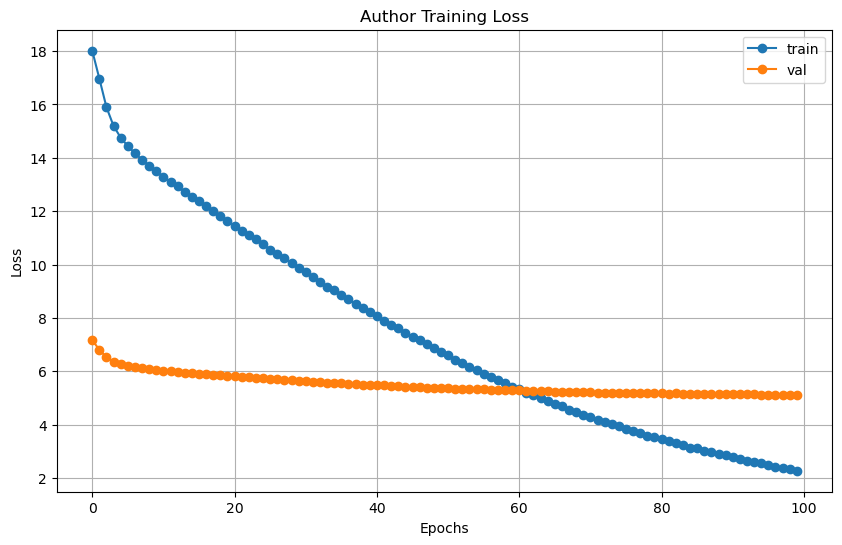

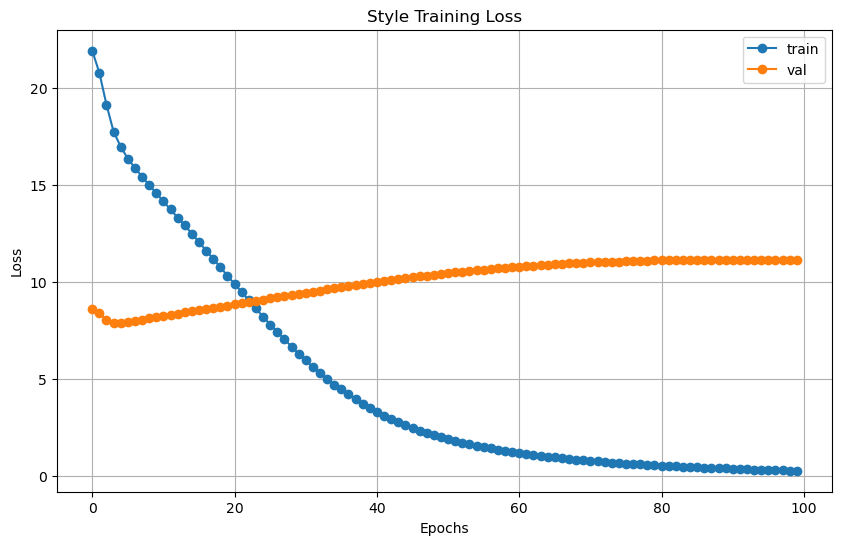

In [ ]:
plot_loss([auth_train_losses,auth_test_loss], "Author Training Loss")
plot_loss([style_train_losses,style_test_loss], "Style Training Loss")
# plot_loss([title_train_losses,title_test_loss], "Title Training Loss")

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


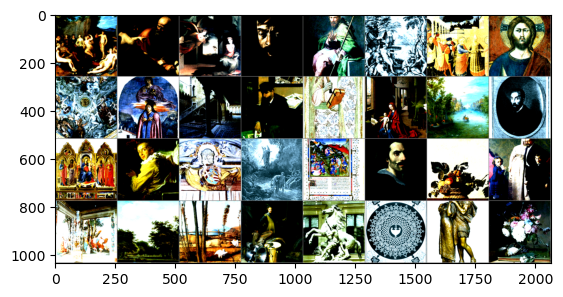

GroundTruth Author:  CORNELIS VAN HAARLEM; CARAVAGGIO; BECCAFUMI, Domenico; CARAVAGGIO
GroundTruth Style:  Oil on canvas, 94 x 114 cm; Oil on canvas, 101 x 93 cm; Charcoal on paper, 369 x 242 mm; Oil on canvas, 101 x 93 cm
GroundTruth Title:  Oil on canvas, 94 x 114 cm; Oil on canvas, 101 x 93 cm; Charcoal on paper, 369 x 242 mm; Oil on canvas, 101 x 93 cm


In [ ]:
dataiter = iter(testloader_auth)

images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth Author: ', '; '.join('%5s' % labels_auth[labels[j]] for j in range(4)))
print('GroundTruth Style: ', '; '.join('%5s' % labels_sty[labels[j]] for j in range(4)))
print('GroundTruth Title: ', '; '.join('%5s' % labels_title[labels[j]] for j in range(4)))


In [ ]:
model_auth.eval()
images = images.to(device)

outputs = model_auth(images)[0].to(device)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', '; '.join('%5s' % labels_auth[predicted[j]] for j in range(4)))

Predicted:  BRONZINO, Agnolo; CARAVAGGIO; CRESPI, Giuseppe Maria; CRANACH, Lucas the Elder


In [ ]:
model_style.eval()
images = images.to(device)
outputs = model_auth(images)[0].to(device)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', '; '.join('%5s' % labels_sty[predicted[j]] for j in range(4)))

In [ ]:
model_auth.eval()
images = images.to(device)
outputs = model_title(images)[0].to(device)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', '; '.join('%5s' % labels_title[predicted[j]] for j in range(4)))

Predicted:  Oil on canvas, 61 x 89 cm; Wood, 103 x 128 cm; Oil on canvas, 183 x 118 cm; Tempera on wood, 49 x 51 cm


In [ ]:
correct = 0
total = 0
test_loss = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader_auth:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs,_,_ = model_auth(images)
        loss = criterion(outputs,labels)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss.append(loss.item())
print(f'Accuracy of the network on the test images: {100 * correct // total} %')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
correct = 0
total = 0
test_loss = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader_style:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs,_,_ = model_style(images)
        loss = criterion(outputs,labels)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss.append(loss.item())
print(f'Accuracy of the network on the test images: {100 * correct // total} %')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
correct = 0
total = 0
test_loss = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader_title:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs,_,_ = model_title(images)
        loss = criterion(outputs,labels)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss.append(loss.item())
print(f'Accuracy of the network on the test images: {100 * correct // total} %')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
